In [1]:
import glob
import random
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import v2

# Traditional Features Construction

In [2]:
def get_image():
    path = "../DataSet/Training/Normal"
    folders = os.listdir(path)
    no_of_images = []
    
    for folder in folders:
        files = [f for f in os.listdir(f"{path}/{folder}") if os.path.isfile(os.path.join(f"../Resized/{folder}", f))]
        no_of_images.append(len(files))
        
    training_collection = {}
    for folder, count in zip(folders, no_of_images):
        all_files = os.listdir(f"{path}/{folder}")
        training_collection[folder] = all_files
        
        
    path = "../DataSet/Testing/Normal"
    folders = os.listdir(path)
    no_of_images = []
    
    for folder in folders:
        files = [f for f in os.listdir(f"{path}/{folder}") if os.path.isfile(os.path.join(f"../Resized/{folder}", f))]
        no_of_images.append(len(files))
        
    testing_collection = {}
    for folder, count in zip(folders, no_of_images):
        all_files = os.listdir(f"{path}/{folder}")
        testing_collection[folder] = all_files
        
    return training_collection, testing_collection

In [3]:
training_image_collection, testing_image_collection = get_image()

In [4]:
def feature_extraction(path, new_path, folder, image):
    path = path + "/" + folder + "/" + image
    loaded_image = cv.imread(path)

    gray = cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    img = cv.drawKeypoints(gray, kp, loaded_image)
    
    new_path = new_path + "/" + folder
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    new_path = new_path + "/" + image
    cv.imwrite(new_path, img)

In [13]:
def get_features(loc="Training"):
    folders = []
    image_collections = training_image_collection
    path = f"../DataSet/{loc}/Normal"
    new_path = f"../DataSet/{loc}/Feature Constructed"

    
    if not os.path.exists(path):
        os.mkdir(path)
    if loc == "Testing":
        image_collections = testing_image_collection
        
    for folder, images in image_collections.items():
        for image in images:
            folders.append(folder)
            feature_extraction(path, new_path, folder, image)
    
    return folders

In [14]:
training_folders = get_features()

In [15]:
def get_dataset(path):
    images = glob.glob(f"../DataSet/{path}/Feature Constructed/*/*")
        
    return images

In [16]:
training_img = get_dataset("Training")

In [17]:
def dataset_target(images, folder):
    targets = {f: 0 for f in folder}  
    for i, a in enumerate(images):
        b = a.split("\\")
        targets[b[1]] += 1
    
    target_images = []
    for i, (k, v) in enumerate(targets.items()):
        target_images = np.concatenate((target_images, np.full(v, i)), axis = 0) 
        
    return target_images

In [18]:
training_images_target = dataset_target(training_img, training_folders)

In [19]:
def plot_img_keypoints(img):    
    img = plt.imread(img)
    plt.imshow(img)

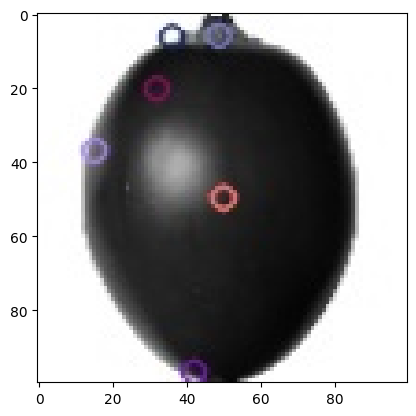

In [20]:
random_image = random.choices(training_img)
plot_img_keypoints(random_image[0])

In [21]:
def create_new_keypoints(image_set=training_img):
    keypoints = []
    
    for image in image_set:
        loaded_image = cv.imread(image)
        gray = cv.cvtColor(loaded_image, cv.COLOR_BGR2GRAY)
        sift = cv.SIFT_create()
        kp, des = sift.detectAndCompute(gray, None)
        
        keypoints.extend(kp)
    
    keypoints = np.array([kp.pt for kp in keypoints])
    
    return keypoints

In [22]:
training_img_keypoints = create_new_keypoints()

In [23]:
def get_pixels(images):
    combine = []
    for img in images:
        loaded_image = cv.imread(img)
        combine.append(loaded_image)
    
    return np.array(combine)

In [24]:
training_images = get_pixels(training_img)

In [25]:
def k_means_clustering(X):
    kmeans = KMeans(n_clusters=100, random_state=0, init="random", n_init="auto").fit(X)    
    return kmeans

In [26]:
def plot_clusters(X):
    plt.scatter(X[:, 0], X[:, 1], s=10, c=kmeans.labels_)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=20, c="r")
    plt.title("KMeans")
    plt.show()

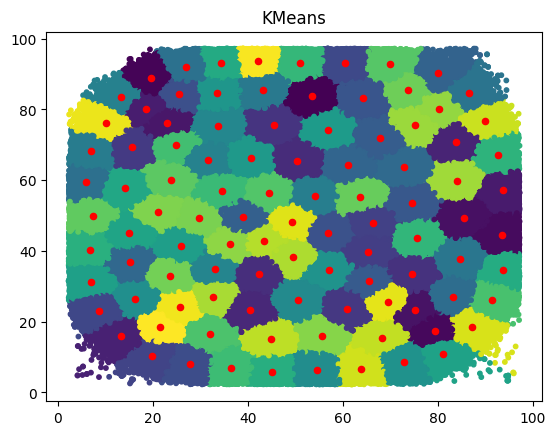

In [27]:
kmeans = k_means_clustering(training_img_keypoints)
plot_clusters(training_img_keypoints)

In [28]:
def k_means_learned_vector_images():
    image_vectors = kmeans.transform(training_img_keypoints)
    return image_vectors

In [29]:
def training_images_vector_images():
    image_vectors = kmeans.transform(training_images)
    return image_vectors

In [ ]:
# a = training_images_vector_images()

# Note: You should not use the class labels ???

In [31]:
def dimension_reduction(features):
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(features)
    
    for i in range(10):
        c = np.flatnonzero(training_images_target == i)
        plt.scatter(transformed_data[c, 0], transformed_data[c, 1])
    plt.show()

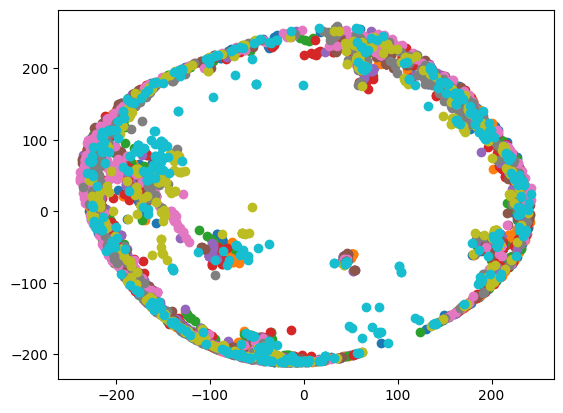

In [32]:
image_vectors = k_means_learned_vector_images()
dimension_reduction(image_vectors)

# Processing Test Images

In [33]:
testing_folders = get_features("Testing")

In [34]:
testing_img = get_dataset("Testing")

In [35]:
testing_images_target = dataset_target(testing_img, testing_folders)

In [36]:
testing_images = get_pixels(testing_img)

In [37]:
testing_img_keypoints = create_new_keypoints(testing_img)

In [38]:
def k_means_learned_vector_images():
    image_vectors = kmeans.transform(testing_img_keypoints)
    return image_vectors

# Traditional Machine Learning model - Support Vecotr Machine (SVM)

In [ ]:
def train_svm(kernel_type="linear"):
    X_train = training_images.reshape(training_images.shape[0], -1)
    X_test = testing_images.reshape(testing_images.shape[0], -1)
    y_train = training_images_target
    y_test = testing_images_target
    
    scores = []
    parameters = [0.001, 0.1, 1.0, 10, 100]
    for c in parameters:
        svc = SVC(kernel=kernel_type, C=c, random_state=42)
        svc.fit(X_train, y_train)
        scores.append(1 - svc.score(X_test, y_test))
    
    return scores

In [30]:
linear_score = train_svm()

(5063, 100, 100, 3)

In [ ]:
def plot_svm_performance():
    plt.plot()

In [ ]:
def train_svm_for_different_kernels():
    scores = []
    kernel_type = "rbf", "poly", "sigmoid"
    for kernel in kernel_type:
        scores.append(train_svm(kernel_type))
    
    scores.insert(0, linear_score)

# Deep Learning - Training a Simple Convolution Neural Network Mode

In [42]:
def get_original_dataset(path):
    images = glob.glob(f"../DataSet/{path}/Normal/*/*")
        
    return images

In [51]:
original_training_image = get_dataset("Training")
original_testing_image = get_dataset("Testing")

original_training_img = get_pixels(original_training_image)
original_testing_img = get_pixels(original_testing_image)

In [72]:
def images_classifier():
    num_classes = 10
    input_shape = (100, 100, 3)
    
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape), 
            layers.Conv2D(8, kernel_size=(3, 3), activation="relu"), 
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),  
            layers.Flatten(), 
            layers.Dense(16, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(num_classes, activation="softmax")
        ]
    )
    
    model.summary()
    
    return model

In [73]:
model = images_classifier()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 8)         224       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 49, 49, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 47, 47, 8)         584       
                                                                 
 flatten_4 (Flatten)         (None, 17672)             0         
                                                                 
 dense_12 (Dense)            (None, 16)                282768    
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                      

In [82]:
def train_model():
    batch_size = 128
    num_epochs = 30
    
    X_train = np.reshape(original_training_img, (original_training_img.shape[0], 100, 100, 3))
    X_test = np.reshape(original_testing_img, (original_testing_img.shape[0], 100, 100, 3))
    
    X_train = X_train.astype("float32") / 255
    X_test = X_test.astype("float32") / 255
    
    y_train = to_categorical(training_images_target, num_classes=10)
    y_test = to_categorical(testing_images_target, num_classes=10)
    
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test))
    
    return model, model_history, X_test, y_test

In [83]:
model, model_history, X_test, y_test = train_model()

Epoch 1/30
40/40 [==============================] - 4s 52ms/step - loss: 0.0317 - accuracy: 0.9903 - val_loss: 0.2508 - val_accuracy: 0.9388
Epoch 2/30
40/40 [==============================] - 2s 40ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2560 - val_accuracy: 0.9347
Epoch 3/30
40/40 [==============================] - 2s 40ms/step - loss: 6.3173e-04 - accuracy: 1.0000 - val_loss: 0.2268 - val_accuracy: 0.9382
Epoch 4/30
40/40 [==============================] - 2s 40ms/step - loss: 4.9374e-04 - accuracy: 1.0000 - val_loss: 0.2224 - val_accuracy: 0.9382
Epoch 5/30
40/40 [==============================] - 2s 40ms/step - loss: 4.1554e-04 - accuracy: 1.0000 - val_loss: 0.2197 - val_accuracy: 0.9406
Epoch 6/30
40/40 [==============================] - 2s 41ms/step - loss: 3.6777e-04 - accuracy: 1.0000 - val_loss: 0.2170 - val_accuracy: 0.9400
Epoch 7/30
40/40 [==============================] - 2s 41ms/step - loss: 3.3326e-04 - accuracy: 1.0000 - val_loss: 0.2199 - val_accuracy: 

In [84]:
def model_evaluation():
    score = model.evaluate(X_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])

In [85]:
model_evaluation()

Test loss: 0.20665183663368225
Test accuracy: 0.9476162195205688


In [88]:
model_history.history

{'loss': [0.03165759518742561,
  0.0013410301180556417,
  0.0006317294901236892,
  0.0004937436315231025,
  0.00041554475319571793,
  0.0003677689819596708,
  0.00033326493576169014,
  0.0002911154297180474,
  0.0002738017647061497,
  0.00023997173411771655,
  0.00021320297673810273,
  0.0001992083271034062,
  0.00018024552264250815,
  0.00016526966646779329,
  0.00015375707880593836,
  0.00013918709009885788,
  0.00013106463302392513,
  0.00012375049118418247,
  0.00011474277562228963,
  0.00010839330934686586,
  0.0001025340097839944,
  9.650264109950513e-05,
  9.22262406675145e-05,
  8.787270780885592e-05,
  8.110637281788513e-05,
  7.581364479847252e-05,
  7.225228910101578e-05,
  6.833354564150795e-05,
  6.541500624734908e-05,
  6.214682798599824e-05],
 'accuracy': [0.990321934223175,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1

In [86]:
def plot_learning_curve():    
    plt.plot(model_history.history["accuracy"], label="Training Accuracy")
    plt.plot(model_history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Number of epochs")
    plt.ylabel("Training and validation accuracy")
    plt.title("Learning curve")
    plt.grid(True)
    plt.legend()
    plt.show()

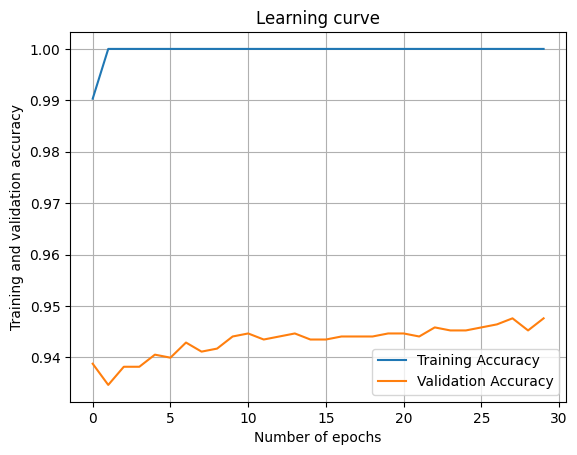

In [87]:
plot_learning_curve()

# Transfer Learning via Feature Extraction

In [ ]:
def preprocessing_read():
    data_transforms = v2.Compose([
        v2.Resize((224,224)),   
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ])

    test_classes = []
    for image in testing_images:
        transformed_images = data_transforms(image)
        test_classes.append(transformed_images)
    
    return test_classes

In [ ]:
test_classes = preprocessing_read()

In [ ]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval()

In [ ]:
accuracy = alexnet(test_classes)    
accuracy

In [ ]:
from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

iris = datasets.load_iris()
X = iris.data[:, 0:2]  # we only take the first two features for visualization
y = iris.target